# Predicting Bacterial Pathogeny using Chaos Game Representations of genomes

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import utilities as utils
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(0)
%matplotlib widget

import gc # to clear memory

## Data Engineering

### Feature Extraction

In [2]:
dataset = 'patho_repr'

In [3]:
print('Generating pathogenic CGR matrices ...')
labels = []
cgr_mats = []
seqs = []
patho_labs = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1)):
        path_to_file = os.path.join(dataset,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        if len(sequence) < 8000:
            continue
        seqs.append(sequence)
        sequence_reverse_complement = utils.reverse_complement(sequence)
        tmp = utils.cgr(sequence, 'ACGT', 7) + utils.cgr(sequence_reverse_complement, 'ACGT', 7)
        cgr_mats.append(tmp)
        labels.append(path_to_file.split('/')[1])
        patho_labs.append(1)

patho_ln = np.array(patho_labs).shape[0]
print(f'{patho_ln} pathogenic CGR matrices were generated.')


Generating pathogenic CGR matrices ...
94 pathogenic CGR matrices were generated.


In [4]:
dataset = 'non_repr'

In [5]:
print('Generating non-pathogenic CGR matrices ...')
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1)):
        path_to_file = os.path.join(dataset,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        if len(sequence) < 8000:
            continue
        seqs.append(sequence)
        sequence_reverse_complement = utils.reverse_complement(sequence)
        tmp = utils.cgr(sequence, 'ACGT', 7) + utils.cgr(sequence_reverse_complement, 'ACGT', 7)
        cgr_mats.append(tmp)
        labels.append(path_to_file.split('/')[1])
        patho_labs.append(0)
non_patho_ln = np.array(patho_labs).shape[0]-patho_ln
print(f'{non_patho_ln} non-pathogenic CGR matrices were generated.')
print(f'{np.array(patho_labs).shape[0]} total CGR matrices were generated.')

Generating non-pathogenic CGR matrices ...
26 non-pathogenic CGR matrices were generated.
120 total CGR matrices were generated.


In [6]:
print('Normalizing and vectorizing CGR matrices ...')
normalized_mats = [mat/np.max(mat) for mat in cgr_mats]
vector_cgrs = [mat.flatten() for mat in normalized_mats]

Normalizing and vectorizing CGR matrices ...


In [7]:
print('Generating CGR plots ...')
plt.clf()
for i, mat in enumerate(normalized_mats):
    plt.imshow(mat, aspect='auto', cmap='gray_r', extent=[0, mat.shape[1], mat.shape[0], 0])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    if i < patho_ln:
        plt.savefig(f'./plots/patho/{i+1}.png',  bbox_inches='tight', pad_inches=0)
    else:
        j = i-patho_ln
        plt.savefig(f'./plots/non_patho/{j+1}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

Generating CGR plots ...


In [8]:
dataset = 'plots'

In [9]:
print('Reading CGR Plots ...')
#labels = []
cgr_p_mats = []
patho_labs = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in [f for f in os.listdir(os.path.join(dataset, dir1)) if not f.startswith('.')]:
        path_to_file = os.path.join(dataset,dir1,file)
        tmp = utils.read_cgr_plot(path_to_file)
        cgr_p_mats.append(tmp)
        if dir1=='patho':
            patho_labs.append(1)
        elif dir1=='non_patho':
            patho_labs.append(0)
print(f'{np.array(patho_labs).shape[0]} CGR plots were loaded')

Reading CGR Plots ...
120 CGR plots were loaded


In [10]:
print('Normalizing and vectorizing CGR plots matrices ...')
normalized_p_mats = [mat/np.max(mat) for mat in cgr_p_mats]
vector_cgrs_p = [mat.flatten() for mat in normalized_p_mats]

Normalizing and vectorizing CGR plots matrices ...


## Exploratory Data Analysis

In [11]:
new_cgrs = []
new_labs = []
new_patho = []
for lab in np.unique(labels):
    idxs = np.where(np.array(labels) == lab)[0]
    new_labs.append(lab)
    new_cgrs.append(np.sum(np.array(cgr_mats)[idxs], axis=0))
    new_patho.append(np.max(np.array(patho_labs)[idxs], axis=0)) #doesnt matter min or max
vector_cgrs = [mat.flatten() for mat in new_cgrs]
print(np.array(new_cgrs).shape)

(53, 128, 128)


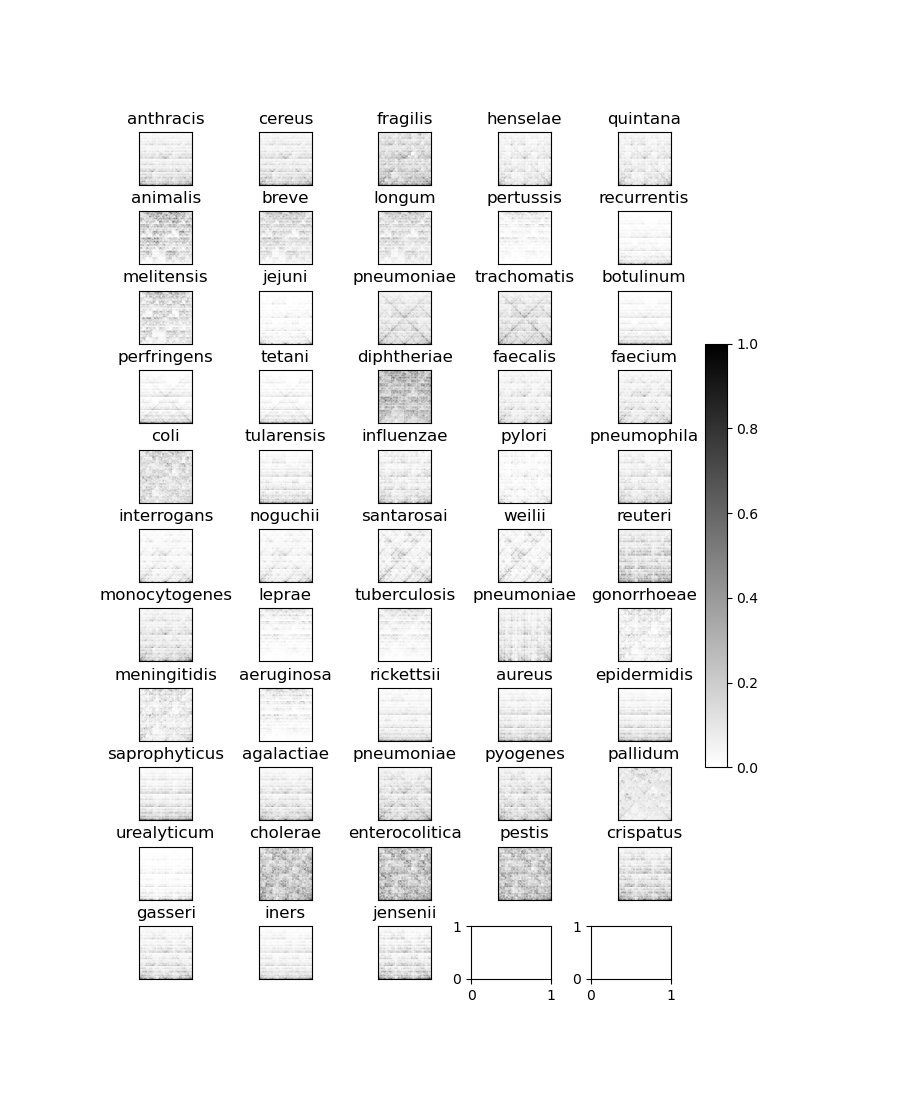

In [12]:
normalized_mats = [mat/np.max(mat) for mat in new_cgrs]
vector_cgrs = [mat.flatten() for mat in normalized_mats]
np.array(normalized_mats).shape
fig,ax = plt.subplots(11,5, figsize=(9,11))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax_flat = ax.flatten()
for axs,cgr,lab in zip(ax_flat, normalized_mats, new_labs):
    axs.set_title(lab.split('_')[-1])
    axs.set_xticks([])
    axs.set_yticks([])
    plot = axs.imshow(cgr, cmap='gray_r')
fig.colorbar(plot, ax=ax, shrink=0.5)
plt.show()

In [13]:
D = pairwise_distances(vector_cgrs_p, metric='manhattan')

In [14]:
print("Performing Multidimensional-Scaling ...")
reduced = utils.perform_mds(D, 3, random_state=0)

Performing Multidimensional-Scaling ...


Plotting the clusters ...


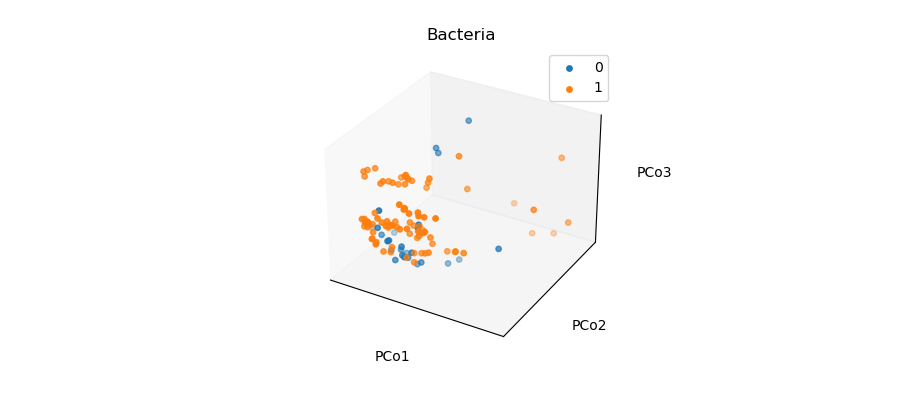

24

In [15]:
print('Plotting the clusters ...')
utils.plot_3d(reduced, patho_labs)
gc.collect()

In [16]:
print('Normlaizing features s.t. mean=0, sd=1')
normalized_mats = [(mat-np.mean(mat))/np.std(mat) for mat in cgr_mats]
vector_cgrs = [mat.flatten() for mat in normalized_mats]
vector_cgrs = np.array([mat.flatten() for mat in normalized_mats])

Normlaizing features s.t. mean=0, sd=1


In [17]:
print('Performing Principal Component Analysis ...')
pca = PCA(n_components=3)
pca.fit(vector_cgrs)
transformed_data = pca.transform(vector_cgrs)
comp1 = transformed_data[:, 0]

Performing Principal Component Analysis ...


In [18]:
cg_content = [(seq.count('C')+seq.count('G'))/len(seq) for seq in seqs]
gt_content = [(seq.count('G')+seq.count('T'))/len(seq) for seq in seqs]
at_content = [(seq.count('A')+seq.count('T'))/len(seq) for seq in seqs]
ag_content = [(seq.count('A')+seq.count('G'))/len(seq) for seq in seqs]
ac_content = [(seq.count('A')+seq.count('C'))/len(seq) for seq in seqs]
ct_content = [(seq.count('C')+seq.count('T'))/len(seq) for seq in seqs]

dct = {'C+G':cg_content,
       'G+T':gt_content,
       'A+T':at_content,
       'A+G':ag_content,
       'A+C':ac_content,
       'C+T':ct_content}

In [19]:
df = pd.DataFrame(dct)

In [20]:
df.describe()[1:]

,C+G,G+T,A+T,A+G,A+C,C+T
mean,0.402999,0.496401,0.597001,0.500071,0.503599,0.499929
std,0.097238,0.015136,0.097238,0.028523,0.015136,0.028523
min,0.260961,0.442643,0.308243,0.425315,0.472469,0.391626
25%,0.338545,0.486729,0.550185,0.486555,0.492391,0.485741
50%,0.380102,0.495440,0.619898,0.497130,0.504560,0.502870
75%,0.449815,0.507609,0.661455,0.514259,0.513271,0.513445
max,0.691757,0.527531,0.739039,0.608374,0.557357,0.574685


In [21]:
cols = df.columns
df['Component_1'] = comp1
df = df[['Component_1']+list(cols[:6])]

In [22]:
df.corr()

,Component_1,C+G,G+T,A+T,A+G,A+C,C+T
Component_1,1.000000,0.951684,-0.083978,-0.951684,-0.067693,0.083978,0.067693
C+G,0.951684,1.000000,-0.113086,-1.000000,-0.098225,0.113086,0.098225
G+T,-0.083978,-0.113086,1.000000,0.113086,0.182345,-1.000000,-0.182345
A+T,-0.951684,-1.000000,0.113086,1.000000,0.098225,-0.113086,-0.098225
A+G,-0.067693,-0.098225,0.182345,0.098225,1.000000,-0.182345,-1.000000
A+C,0.083978,0.113086,-1.000000,-0.113086,-0.182345,1.000000,0.182345
C+T,0.067693,0.098225,-0.182345,-0.098225,-1.000000,0.182345,1.000000


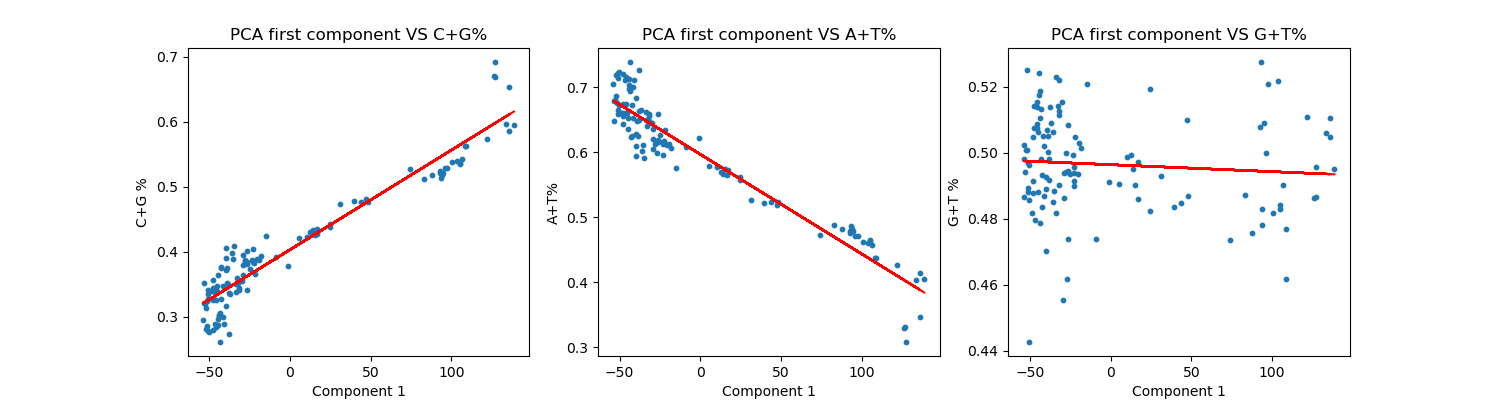

In [23]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs[0].scatter(comp1, cg_content, s=10)
axs[0].set_title('PCA first component VS C+G%')
slope, intercept = np.polyfit(comp1, cg_content, 1)
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('C+G %')
axs[0].plot(comp1, slope*comp1+intercept, c='r')

axs[1].scatter(comp1, at_content, s=10)
axs[1].set_title('PCA first component VS A+T%')
slope, intercept = np.polyfit(comp1, at_content, 1)
axs[1].set_xlabel('Component 1')
axs[1].set_ylabel('A+T%')
axs[1].plot(comp1, slope*comp1+intercept, c='r')

axs[2].scatter(comp1, gt_content, s=10)
axs[2].set_title('PCA first component VS G+T%')
slope, intercept = np.polyfit(comp1, gt_content, 1)
axs[2].set_xlabel('Component 1')
axs[2].set_ylabel('G+T %')
axs[2].plot(comp1, slope*comp1+intercept, c='r')
plt.show()

## Model Deployment

In [24]:
FOLDS = 10
print('Initializing the model (Random Forest) ...')
clf_rf = RandomForestClassifier(criterion='gini',max_depth=3, random_state=1)
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=1)

Initializing the model (Random Forest) ...


In [25]:
print('Normlaizing features s.t. mean=0, sd=1')
#normalized_mats = [(mat-np.mean(mat))/np.std(mat) for mat in cgr_p_mats]
normalized_mats = [mat for mat in cgr_p_mats]

vector_cgrs = [mat.flatten() for mat in normalized_mats]
vector_cgrs = np.array([mat.flatten() for mat in normalized_mats])

Normlaizing features s.t. mean=0, sd=1


In [26]:
print('Stratified K-Fold evaluation ...')
accs_rf = []
for train_i, test_j in kf.split(vector_cgrs, patho_labs):
    X_train, X_test = vector_cgrs[train_i], vector_cgrs[test_j]
    y_train, y_test = np.array(patho_labs)[train_i], np.array(patho_labs)[test_j]
    clf_rf.fit(X_train, y_train)
    y_preds = clf_rf.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_preds)
    accs_rf.append(accuracy)
for i,score in enumerate(accs_rf):
    print(f'Fold {i+1}: {score}')
print(f'Model accuracy: {np.mean(accs_rf)}')

Stratified K-Fold evaluation ...
Fold 1: 75.0
Fold 2: 100.0
Fold 3: 100.0
Fold 4: 83.33333333333334
Fold 5: 91.66666666666666
Fold 6: 91.66666666666666
Fold 7: 75.0
Fold 8: 91.66666666666666
Fold 9: 91.66666666666666
Fold 10: 100.0
Model accuracy: 90.0


In [33]:
print('Splitting the dataset (test_size=20%) ...')
X_tr, X_t, y_tr, y_t = train_test_split(vector_cgrs, patho_labs, test_size=0.20, random_state=0)

Splitting the dataset (test_size=20%) ...


In [34]:
print('Training the model ...')
clf_rf.fit(X_tr, y_tr)

Training the model ...


RandomForestClassifier(max_depth=3, random_state=1)

In [35]:
print('Predicting pathogenicity on testing data ...')
preds = clf_rf.predict(X_t)
print(f'Model accuracy: {accuracy_score(y_t, preds)}')

Predicting pathogenicity on testing data ...
Model accuracy: 0.875


Displaying confusion matrix: 


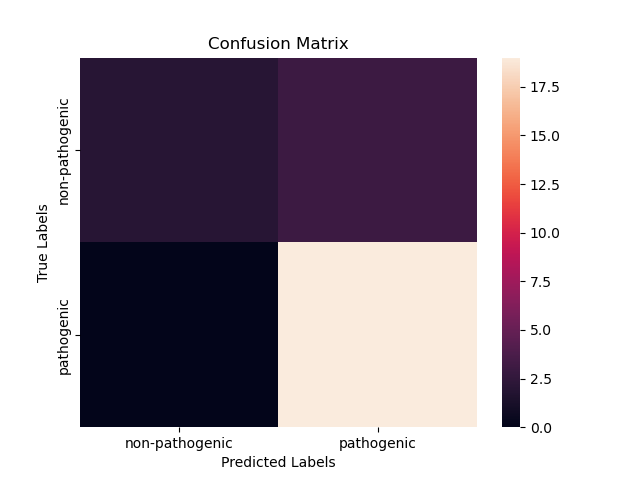

In [36]:
print('Displaying confusion matrix: ')
labs = ['non-pathogenic', 'pathogenic']
cm = confusion_matrix(y_t, preds)
plt.figure()
sns.heatmap(cm, xticklabels=labs, yticklabels=labs)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()